# Standard Preprocessing


**Steps**:

1. Load CONUS dataset (5D, 14D temporal resolution)
2. Subset Area of Interest (AOI)
3. Interpolate the NANs
4. Smooth the Signal
5. Calculate the anomalies (remove the climatology)


## Package Preamble

In [105]:
import sys
from pyprojroot import here

# spyder up to find the root
root = here(project_files=[".here"])


# append to path
sys.path.append(str(here()))
sys.path.append("/home/emmanuel/code/isp_data")

# standard libraries
import geopandas as gpd
import xarray as xr

xr.set_options(display_style="html")


# Helper Functions
from isp_data.drought.load import DroughtData
from isp_data.polygons import get_local_polygons
from isp_data.viz import plot_mean_time

# Plot functions
import matplotlib.pyplot as plt


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1 - Load Drought Data

In [63]:
region = 'conus'
sampling = '5D'

drought_data = DroughtData()

drought_cube = drought_data.load_data(region, sampling)

drought_cube

<xarray.Dataset>
Dimensions:  (lat: 461, lon: 865, time: 526)
Coordinates:
  * time     (time) datetime64[ns] 2010-05-30 2010-06-01 ... 2015-12-30
  * lat      (lat) float64 25.88 25.93 25.98 26.03 ... 48.74 48.79 48.84 48.89
  * lon      (lon) float64 -124.4 -124.3 -124.2 -124.2 ... -80.64 -80.59 -80.54
Data variables:
    SMADI    (lat, lon, time) float64 ...
    LST      (lat, lon, time) float64 ...
    NDVI     (lat, lon, time) float64 ...
    VOD      (lat, lon, time) float64 ...
    SM       (lat, lon, time) float64 ...

### 1.1 - Demo Plot

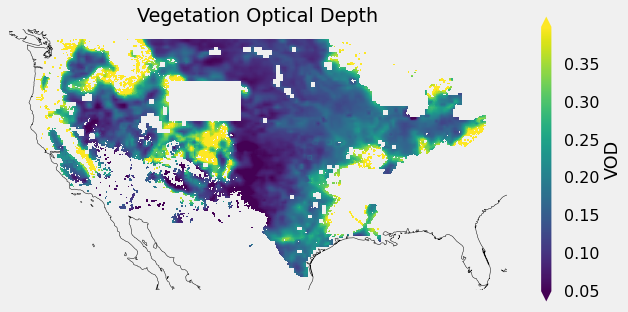

In [64]:
# plot
plot_mean_time(drought_cube.VOD, cmap="viridis", title="Vegetation Optical Depth", );

## 2.0 - Subset Area of Interest

In this case, we're going to take a single pixel as our demonstration. Ideally we would want to take a larger area but for the purposes of this demo, we just need a single time series.

In [106]:
from isp_data.esdc.subset import select_pixel

pixel = (-121, 37)

demo_pixel = select_pixel(drought_cube, pixel, method='nearest')

In [66]:
demo_pixel

<xarray.Dataset>
Dimensions:  (time: 526)
Coordinates:
  * time     (time) datetime64[ns] 2010-05-30 2010-06-01 ... 2015-12-30
    lat      float64 36.99
    lon      float64 -121.0
Data variables:
    SMADI    (time) float64 ...
    LST      (time) float64 ...
    NDVI     (time) float64 ...
    VOD      (time) float64 0.193 nan 0.1894 0.2182 ... 0.1777 nan 0.1379 0.1947
    SM       (time) float64 ...

#### 2.1 - Plot the Time Series

In [67]:
def plot_ts(ds):
    fig, ax = plt.subplots(nrows=4, figsize=(10,10))


    ds.to_dataframe()[["VOD"]].plot(ax=ax[0], color="Blue")
    ds.to_dataframe()[["LST"]].plot(ax=ax[1], color="Red")
    ds.to_dataframe()[["NDVI"]].plot(ax=ax[2], color="Green")
    ds.to_dataframe()[["SM"]].plot(ax=ax[3], color="Red")

    plt.tight_layout()
    plt.show()

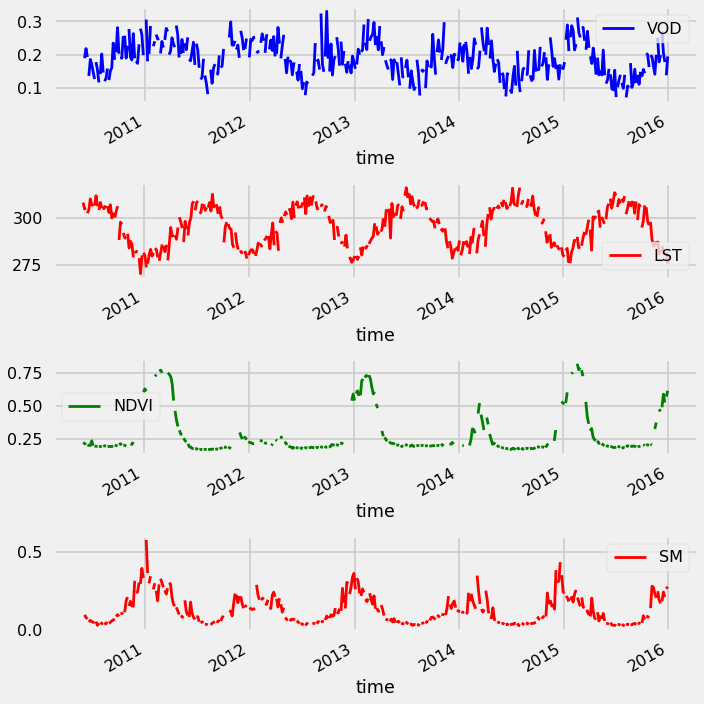

In [68]:
fig, ax = plt.subplots(nrows=4, figsize=(10,10))

demo_pixel.to_dataframe()[["VOD"]].plot(ax=ax[0], color="Blue")
demo_pixel.to_dataframe()[["LST"]].plot(ax=ax[1], color="Red")
demo_pixel.to_dataframe()[["NDVI"]].plot(ax=ax[2], color="Green")
demo_pixel.to_dataframe()[["SM"]].plot(ax=ax[3], color="Red")

plt.tight_layout()
plt.show()

### 2.2 - Plot the Average Monthly Time Series

In [88]:
def plot_avg_monthly_ts(ds):
    fig, ax = plt.subplots(nrows=4, figsize=(10,10))

    ds_monthly = ds.groupby("time.month").median()

    ds_monthly.to_dataframe()[["VOD"]].plot(ax=ax[0], color="Blue")
    ds_monthly.to_dataframe()[["LST"]].plot(ax=ax[1], color="Red")
    ds_monthly.to_dataframe()[["NDVI"]].plot(ax=ax[2], color="Green")
    ds_monthly.to_dataframe()[["SM"]].plot(ax=ax[3], color="Red")

    plt.tight_layout()
    plt.show()

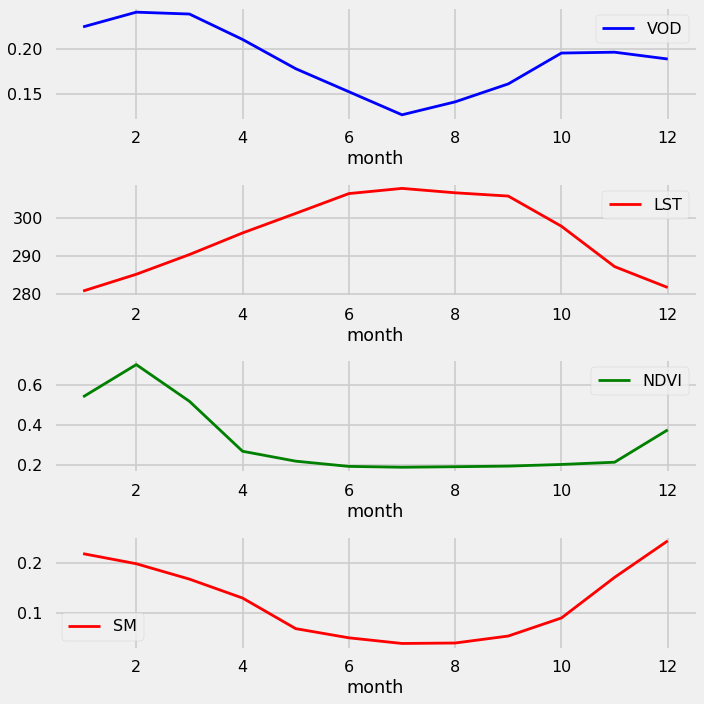

In [89]:
plot_avg_monthly_ts(demo_pixel)

## 3.0 - Interpolate NANs

In [73]:
# interpolation arguments
interp_dim = 'time'
method = 'slinear'

# do interpolation
demo_pixel_interp = demo_pixel.interpolate_na(
    dim=interp_dim, 
    method=method
)

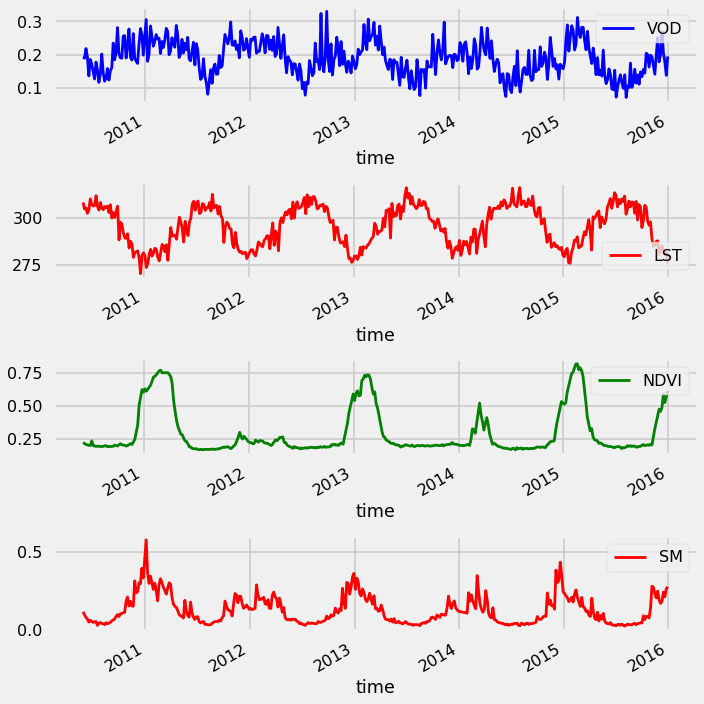

In [95]:
plot_ts(demo_pixel_interp)

## 4.0 - Smooth Signal

So here, we want to be able to smooth the signal

#### 4.1 - Rolling Mean

In [103]:
# savgol filter params
window_length = 3

# apply savgol filter
demo_pixel_interp_rolling = demo_pixel_interp.rolling(
    time=window_length, 
    center=True
).mean()

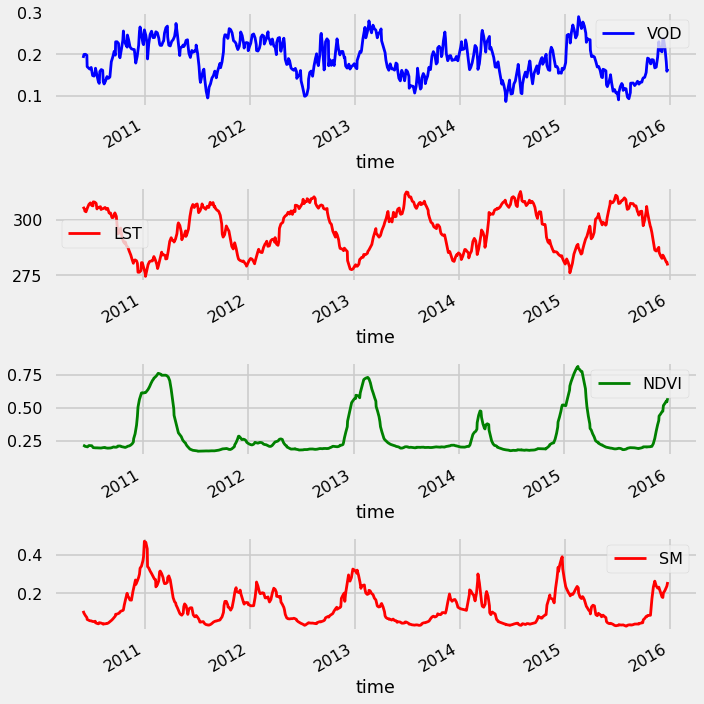

In [104]:
plot_ts(demo_pixel_interp_rolling)

#### 4.2 - Savgol Filter

In [96]:
%%time

from scipy.signal import savgol_filter

# savgol filter params
window_length = 5
polyorder = 3

# apply to all pixels
demo_pixel_interp_savgol = xr.apply_ufunc(
    savgol_filter,
    demo_pixel_interp,
    input_core_dims=[[]],
    output_core_dims=[[]],
    kwargs={
        'window_length': window_length,
        'polyorder': polyorder
    }
)

CPU times: user 5.11 ms, sys: 2.12 ms, total: 7.23 ms
Wall time: 6.28 ms


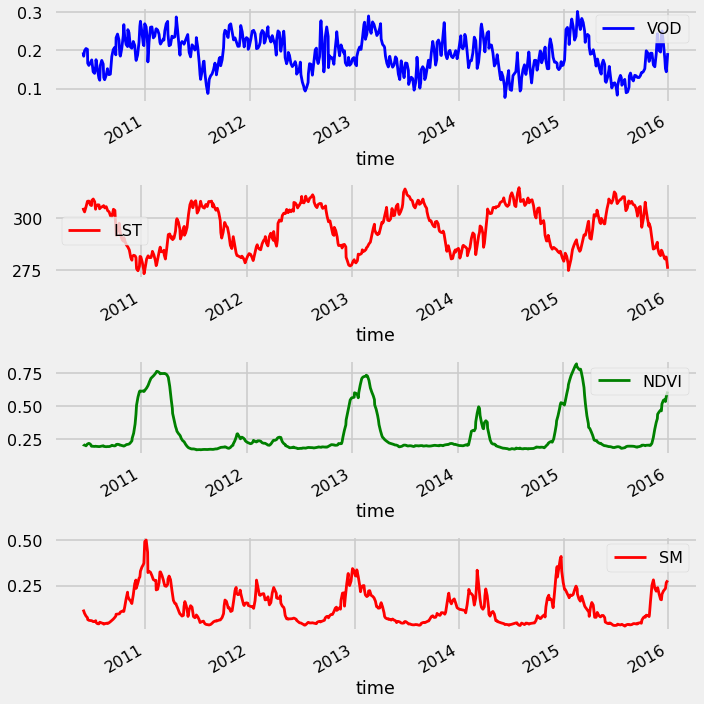

In [97]:
plot_ts(demo_pixel_interp_savgol)

## 5.0 - Climatology

Often times, we need to remove the climatology of our signal

In [111]:
from isp_data.esdc.decomposition import calculate_monthly_mean

# calculate the climatology
demo_pixel_climatology_mean = calculate_monthly_mean(demo_pixel_interp_rolling)


#### 5.1 - Monthly Mean

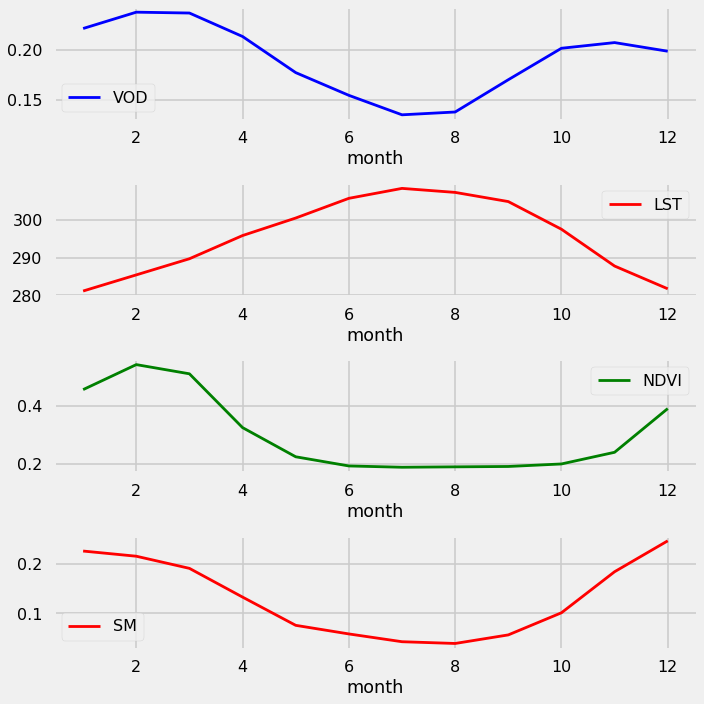

In [115]:
plot_ts(demo_pixel_climatology_mean)

In [113]:

# remove climatology
demo_pixel_anomalies = demo_pixel_interp_rolling.groupby('time.month') - demo_pixel_climatology_mean

#### 5.2 - Anomalies

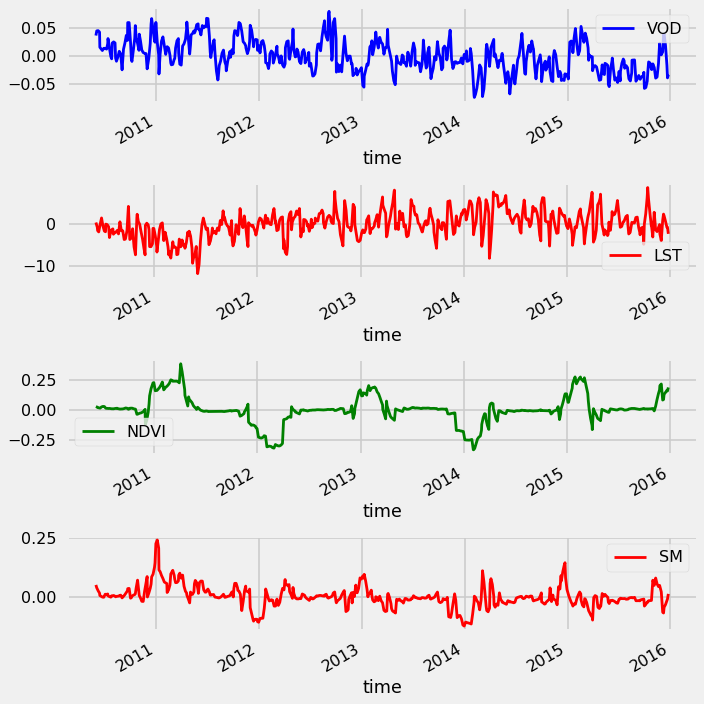

In [116]:
plot_ts(demo_pixel_anomalies)